## SA-CCR and ISDA SIMM Euler allocation under a perfect hedge

The goal is to create a portfolio with a perfect hedge and see if and under which circumstances EAD allocation is still possible.
We load two perfectly offsetting IRS (one payer, one receiver). To avoid the unrealistic case of a zero IM and EAD portfolio we add an unrelated equity option into the portfolio.

In [1]:
import QuantLib as ql
from IPython.core.display import display, Markdown, Image
from numpy.core._multiarray_umath import arange
from allocation.Enums import FdApproach2
from allocation.eulerAllocator import EulerAllocator
from collateralAgreement.collateralAgreement import CollateralAgreement
from instruments.Trade import Trade
from instruments.equity_instruments.equityOption import EquityOption
from instruments.interestRateInstrument.irs import IRS
from jupyterUtils import export, exportPlotlyFigure
from marketdata import init_marketdata
from marketdata.interestRateIndices import InterestRateIndex
from sa_ccr.sa_ccr import SA_CCR
from utilities.Enums import SwapDirection, Stock, TradeType, TradeDirection
import pandas as pd
import plotly.express as px
import ast

asdf =1

In [2]:
IRS_pay = IRS(notional=100000000,
              timeToSwapStart=ql.Period(2, ql.Days),
              timeToSwapEnd=ql.Period(10, ql.Years),
              swapDirection=SwapDirection.PAYER,
              index=InterestRateIndex.USDLIBOR3M)

IRS_rec = IRS(notional=100000000,
              timeToSwapStart=ql.Period(2, ql.Days),
              timeToSwapEnd=ql.Period(10, ql.Years),
              swapDirection=SwapDirection.RECEIVER,
              index=InterestRateIndex.USDLIBOR3M)

eqOpt = EquityOption(notional = 1000000,
                     underlying=Stock.ADS,
                     tradeType = TradeType.CALL,
                     tradeDirection = TradeDirection.LONG,
                     maturity = ql.Period(1, ql.Years))

ca = CollateralAgreement()
ca.link_sa_ccr_instance(SA_CCR(ca))

In [3]:
ca.add_trades([IRS_pay, IRS_rec, eqOpt])
print(ca.get_sa_ccr_model().get_risk_measure())
print(ca.get_im_model().get_risk_measure())

1315355.6739375147
6952717.387110085


We now create an Euler allocator which can be used to perform a numerical Euler allocation of the ISDA-SIMM IM or the SA-CCR EAD risk measure.
The allocator can be set to use forward, backward or central differentiation.
We will see that the differentiation approach makes a big difference for this perfectly hedged portfolio.

In [4]:

eulerAllocator = EulerAllocator(ca)
im_alloc_forward = eulerAllocator.allocate_im()
saccr_alloc_forward = eulerAllocator.allocate_ead()

eulerAllocator.fdApproach2=FdApproach2.Central
im_alloc_central = eulerAllocator.allocate_im()
saccr_alloc_central = eulerAllocator.allocate_ead()

eulerAllocator.fdApproach2=FdApproach2.Backward
im_alloc_backward = eulerAllocator.allocate_im()
saccr_alloc_backward = eulerAllocator.allocate_ead()

In [5]:
def display_table(forward, central, backward):
    import pandas as pd
    import ast
    df = pd.DataFrame()
    for key, value in forward.items():
        name = ast.literal_eval(str(key))['Instrument'] + '_' + ast.literal_eval(str(key))['TradeDirection']
        df = df.append({'Trade':name,
                   'Forward':value,
                   'Central':central[key],
                   'Backward':backward[key]},ignore_index=True)
    df.set_index('Trade', inplace=True)
    df.index.name = None
    df.loc['Sum'] = df.sum()
    return df

In [6]:
display(Markdown('Below the resulting allocation for the IM is displayed. The allocation only exhibits nativ additivity when using the central difference approach since then the allocated values sum up to the IM value of %.2f USD.' %ca.get_im_model().get_risk_measure()))

Below the resulting allocation for the IM is displayed. The allocation only exhibits nativ additivity when using the central difference approach since then the allocated values sum up to the IM value of 6952717.39 USD.

In [7]:
display_table(im_alloc_forward, im_alloc_central, im_alloc_backward)

,Backward,Central,Forward
IRS_Long,-4.518969e+06,-2.421718e-01,4.518969e+06
IRS_Short,-4.519001e+06,-6.323463e+01,4.518937e+06
EquityOption_Long,6.952717e+06,6.952717e+06,6.952717e+06
Sum,-2.085253e+06,6.952654e+06,1.599062e+07


In [8]:
display(Markdown('Below the resulting allocation for the EAD is displayed. The allocation only exhibits nativ additivity when using the central difference approach since then the allocated values sum up to the IM value of %.2f USD.' %ca.get_sa_ccr_model().get_risk_measure()))

Below the resulting allocation for the EAD is displayed. The allocation only exhibits nativ additivity when using the central difference approach since then the allocated values sum up to the IM value of 1315355.67 USD.

In [9]:
display_table(saccr_alloc_forward, saccr_alloc_central, saccr_alloc_backward)

,Backward,Central,Forward
IRS_Long,-1.884133e+05,4.845671e-02,1.884134e+05
IRS_Short,-1.884070e+05,1.265202e+01,1.884196e+05
EquityOption_Long,1.315356e+06,1.315356e+06,1.315356e+06
Sum,9.385354e+05,1.315368e+06,1.692189e+06


In [10]:
EAD_IRSpay_forward = saccr_alloc_forward[IRS_pay]
EAD_IRSrec_forward = saccr_alloc_forward[IRS_rec]
EAD_EqOpt_forward = saccr_alloc_forward[eqOpt]
EAD_forward_sum = EAD_EqOpt_forward+EAD_IRSpay_forward+EAD_IRSrec_forward
Delta_EAD_forward = ca.get_sa_ccr_model().get_risk_measure() - EAD_forward_sum

EAD_IRSpay_central = saccr_alloc_central[IRS_pay]
EAD_IRSrec_central = saccr_alloc_central[IRS_rec]
EAD_EqOpt_central = saccr_alloc_central[eqOpt]
EAD_central_sum = EAD_EqOpt_central+EAD_IRSpay_central+EAD_IRSrec_central
Delta_EAD_central = ca.get_sa_ccr_model().get_risk_measure() - EAD_central_sum

EAD_IRSpay_backward = saccr_alloc_backward[IRS_pay]
EAD_IRSrec_backward = saccr_alloc_backward[IRS_rec]
EAD_EqOpt_backward = saccr_alloc_backward[eqOpt]
EAD_backward_sum = EAD_EqOpt_backward+EAD_IRSpay_backward+EAD_IRSrec_backward
Delta_EAD_backward = ca.get_sa_ccr_model().get_risk_measure() - EAD_backward_sum

IM_IRSpay_forward = im_alloc_forward[IRS_pay]
IM_IRSrec_forward = im_alloc_forward[IRS_rec]
IM_EqOpt_forward = im_alloc_forward[eqOpt]
IM_forward_sum = IM_EqOpt_forward+IM_IRSpay_forward+IM_IRSrec_forward
Delta_IM_forward = ca.get_sa_ccr_model().get_risk_measure() - IM_forward_sum

IM_IRSpay_central = im_alloc_central[IRS_pay]
IM_IRSrec_central = im_alloc_central[IRS_rec]
IM_EqOpt_central = im_alloc_central[eqOpt]
IM_central_sum = IM_EqOpt_central+IM_IRSpay_central+IM_IRSrec_central
Delta_IM_central = ca.get_sa_ccr_model().get_risk_measure() - IM_central_sum

IM_IRSpay_backward = im_alloc_backward[IRS_pay]
IM_IRSrec_backward = im_alloc_backward[IRS_rec]
IM_EqOpt_backward = im_alloc_backward[eqOpt]
IM_backward_sum = IM_EqOpt_backward+IM_IRSpay_backward+IM_IRSrec_backward
Delta_IM_backward = ca.get_im_model().get_risk_measure() - IM_backward_sum

pf_ead = ca.get_sa_ccr_model().get_risk_measure()
pf_im = ca.get_im_model().get_risk_measure()

The reason for the Euler allocation not working is that the SA-CCR is not differentiable in case of a perfect hedge. This can be shown by plotting the function SA-CCR w.r.t. the position size in the three trades.

In [11]:
bumps = arange(-0.05, 0.06, 0.01)

In [12]:
def bump_one_trade_and_return_diff(bump, trade: Trade, ca: CollateralAgreement, method):
    base = method()
    ca.remove_trades(trade)
    bumped_trade = trade.get_bumped_copy(rel_bump_size=bump)
    ca.add_trades(bumped_trade)
    result = method()
    ca.remove_trades(bumped_trade)
    ca.add_trades(trade)
    return result-base

In [13]:
result_df = pd.DataFrame()

for t in ca.trades:
    for bump in bumps:
        record = \
            {'Relative change in position size': bump,
             'Change in EAD':
                 bump_one_trade_and_return_diff(
                     bump, t, ca,
                     ca.get_sa_ccr_model().get_risk_measure),
             'Legend':
                 ast.literal_eval(str(t))['Instrument'] + '_'
                 + ast.literal_eval(str(t))['TradeDirection']
             }

        result_df = result_df.append(record, ignore_index=True)

Displaying ``result_df`` yields:

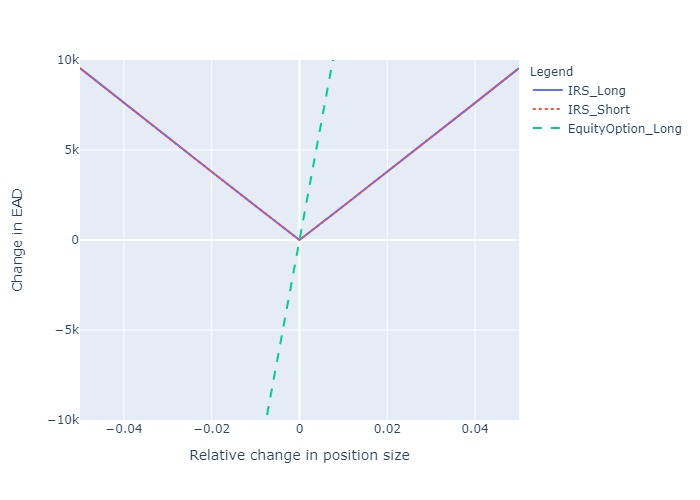

In [14]:
fig = px.line(result_df, x='Relative change in position size', y='Change in EAD', color='Legend', line_dash='Legend')
fig.update_yaxes(range=[-10000,10000])
exportPlotlyFigure(fig, 'Indifferentiabililty_of_EAD')
img_bytes = fig.to_image(format='jpeg')
Image(img_bytes)

Do the same for the IM:

In [15]:
result_df = pd.DataFrame()

for t in ca.trades:
    for bump in bumps:
        record = \
            {'Relative change in position size': bump,
             'Change in calculated IM': bump_one_trade_and_return_diff(
                 bump, t, ca,
                 ca.get_im_model().get_risk_measure),
             'Legend':
                 ast.literal_eval(str(t))['Instrument'] + '_'
                 + ast.literal_eval(str(t))['TradeDirection']
             }

        result_df = result_df.append(record, ignore_index=True)

Displaying ``result_df`` yields:

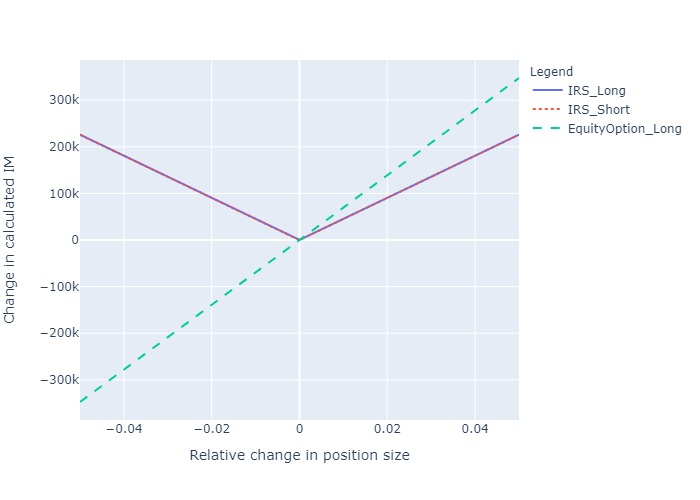

In [16]:
fig = px.line(result_df, x='Relative change in position size', y='Change in calculated IM', color='Legend', line_dash='Legend')
exportPlotlyFigure(fig, 'Indifferentiabililty_of_IM')
img_bytes = fig.to_image(format='jpeg')
Image(img_bytes)

The same phenomenon does not appear for if a hedge is not perfect i.e. if the hedge size can be increased to further diminish the risk metric.

In [17]:
IRS_pay = IRS(notional=200000000,
              timeToSwapStart=ql.Period(2, ql.Days),
              timeToSwapEnd=ql.Period(10, ql.Years),
              swapDirection=SwapDirection.PAYER,
              index=InterestRateIndex.USDLIBOR3M)

IRS_rec = IRS(notional=100000000,
              timeToSwapStart=ql.Period(2, ql.Days),
              timeToSwapEnd=ql.Period(10, ql.Years),
              swapDirection=SwapDirection.RECEIVER,
              index=InterestRateIndex.USDLIBOR3M)

eqOpt = EquityOption(notional = 1000000)

In [18]:
ca = CollateralAgreement()
ca.link_sa_ccr_instance(SA_CCR(ca))

ca.add_trades([IRS_rec, IRS_pay, eqOpt])

eulerAllocator = EulerAllocator(ca)
im_alloc_forward = eulerAllocator.allocate_im()
saccr_alloc_forward = eulerAllocator.allocate_ead()

eulerAllocator.fdApproach2=FdApproach2.Central
im_alloc_central = eulerAllocator.allocate_im()
saccr_alloc_central = eulerAllocator.allocate_ead()

eulerAllocator.fdApproach2=FdApproach2.Backward
im_alloc_backward = eulerAllocator.allocate_im()
saccr_alloc_backward = eulerAllocator.allocate_ead()

In [19]:
display(Markdown('The IM for this portfolio is %.2f USD and the EAD is %.2f USD.' %(ca.get_im_model().get_risk_measure(), ca.get_sa_ccr_model().get_risk_measure())))

The IM for this portfolio is 11471795.91 USD and the EAD is 1538770.53 USD.

For the IM the allocation yields:

In [20]:
display_table(im_alloc_forward, im_alloc_central, im_alloc_backward)

,Backward,Central,Forward
IRS_Short,-4.519079e+06,-4.519078e+06,-4.519079e+06
IRS_Long,9.038157e+06,9.038157e+06,9.038157e+06
EquityOption_Long,6.952717e+06,6.952717e+06,6.952717e+06
Sum,1.147180e+07,1.147180e+07,1.147180e+07


and for the EAD the different differentiation approaches yield:

In [21]:
display_table(saccr_alloc_forward, saccr_alloc_central, saccr_alloc_backward)

,Backward,Central,Forward
IRS_Short,-2.466093e+05,-2.466078e+05,-2.466063e+05
IRS_Long,4.932094e+05,4.932156e+05,4.932217e+05
EquityOption_Long,1.292161e+06,1.292163e+06,1.292164e+06
Sum,1.538761e+06,1.538771e+06,1.538780e+06


In [24]:
export('SA-CCR and ISDA SIMM under perfect hedge.ipynb')